In [71]:
from tensorflow.keras.datasets import cifar10
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Dataset Load

In [72]:
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

In [73]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [74]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [75]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
               'horse', 'sheep', 'truck']

In [76]:
sample_size = 9
random_idx = np.random.randint(len(X_train), size=sample_size)

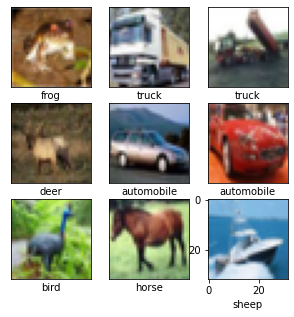

In [77]:
plt.figure(figsize=(5,5))
for i, idx in enumerate(random_idx):
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

## Preprocessing

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [79]:
x_mean = np.mean(X_train, axis=(0,1,2))
x_std = np.std(X_train, axis=(0,1,2))

X_train = (X_train - x_mean) / x_std
X_test = (X_test - x_mean) / x_std

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.3)

## Model Struct

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [81]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', 
           input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

In [82]:
model.compile(optimizer=Adam(1e-4), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Model Train

In [83]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
1094/1094 [==============================] - 9s 8ms/step - loss: 1.8444 - accuracy: 0.3264 - val_loss: 1.3693 - val_accuracy: 0.5087
Epoch 2/20
1094/1094 [==============================] - 8s 8ms/step - loss: 1.3064 - accuracy: 0.5335 - val_loss: 1.2025 - val_accuracy: 0.5735
Epoch 3/20
1094/1094 [==============================] - 8s 7ms/step - loss: 1.1170 - accuracy: 0.6082 - val_loss: 1.0648 - val_accuracy: 0.6166
Epoch 4/20
1094/1094 [==============================] - 8s 8ms/step - loss: 0.9672 - accuracy: 0.6571 - val_loss: 0.9884 - val_accuracy: 0.6523
Epoch 5/20
1094/1094 [==============================] - 9s 8ms/step - loss: 0.8469 - accuracy: 0.7077 - val_loss: 0.8998 - val_accuracy: 0.6845
Epoch 6/20
1094/1094 [==============================] - 10s 9ms/step - loss: 0.7488 - accuracy: 0.7403 - val_loss: 0.8557 - val_accuracy: 0.7041
Epoch 7/20
1094/1094 [==============================] - 9s 8ms/step - loss: 0.6668 - accuracy: 0.7688 - val_loss: 0.7888 - val_accuracy

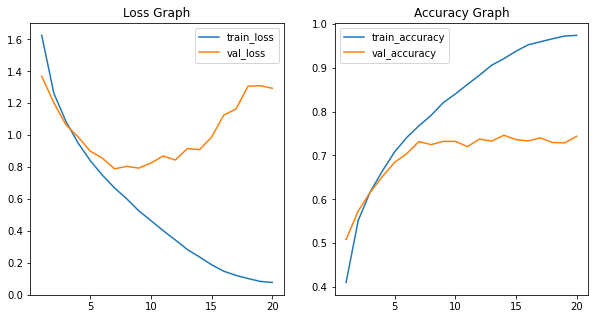

In [84]:
from history_plot import *
draw_history(history)

In [85]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.3409 - accuracy: 0.7326


[1.3408983945846558, 0.7325999736785889]

## Neural Network Visualize 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


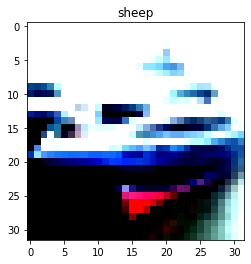

In [86]:
plt.imshow(X_test[1])
plt.title(class_names[y_test[1][0]])
plt.show()

<ipython-input-87-366373dde09d>:21: RuntimeWarning: invalid value encountered in true_divide
  x = (x - x.mean()) / x.std()


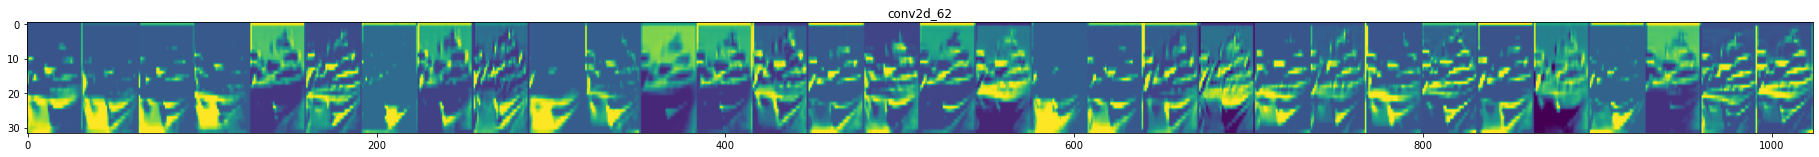

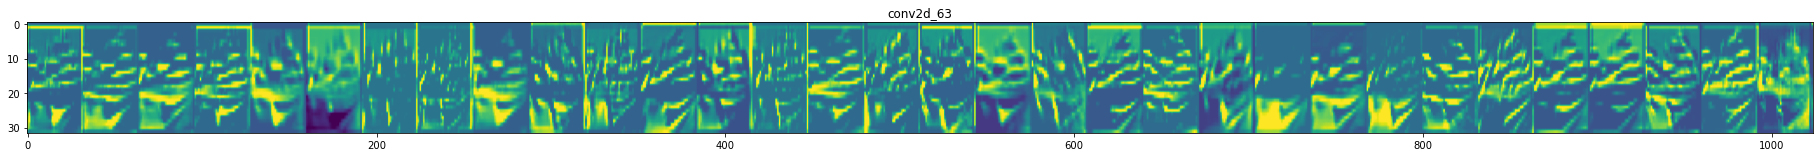

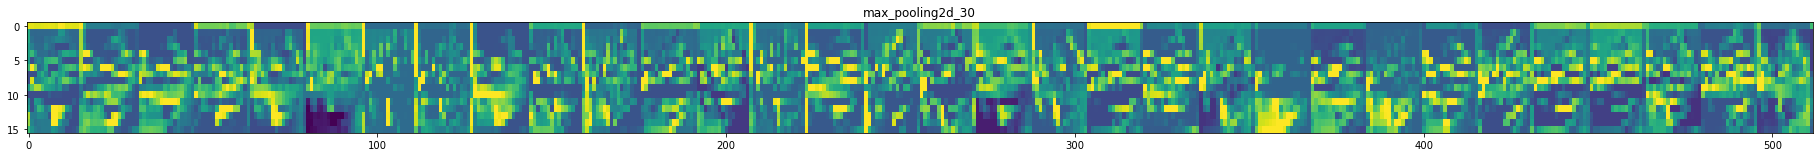

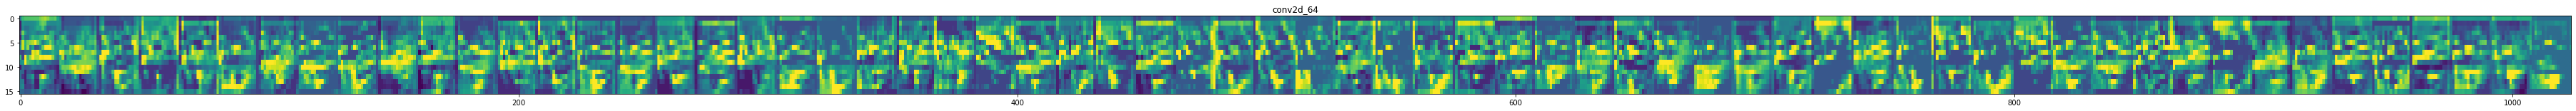

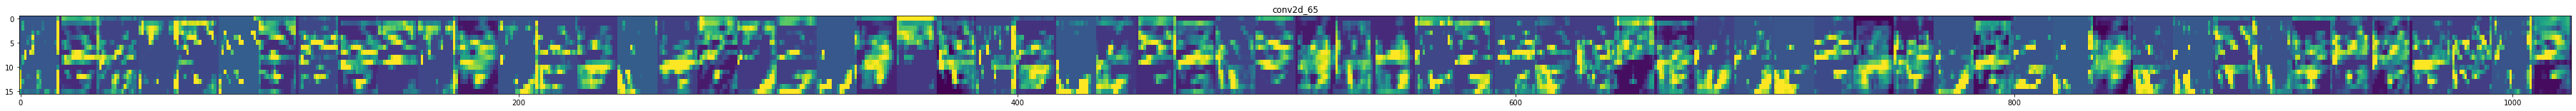

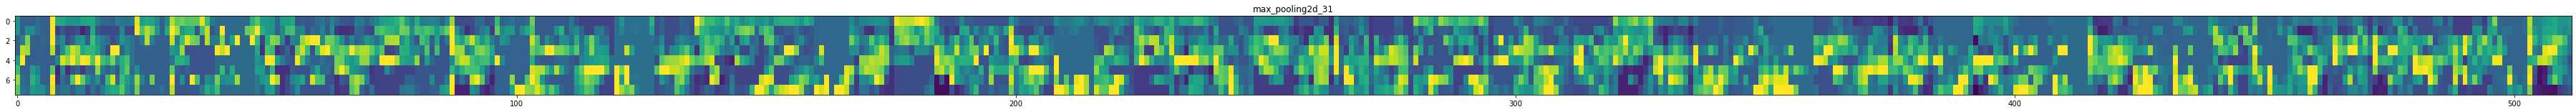

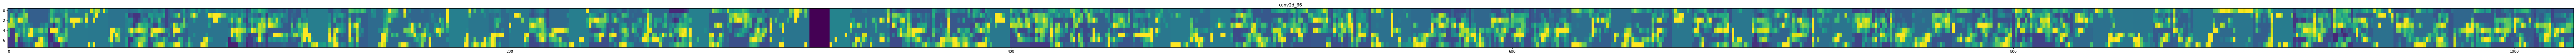

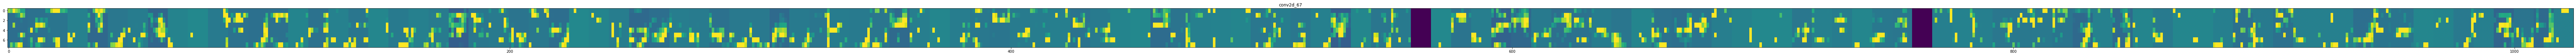

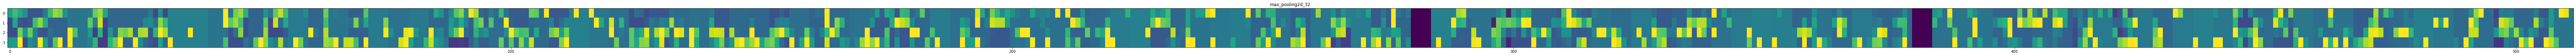

In [87]:
import tensorflow as tf

get_layer_name = [layer.name for layer in model.layers]
get_output = [layer.output for layer in model.layers]

visual_model = tf.keras.models.Model(inputs=model.input, outputs=get_output)

test_img = np.expand_dims(X_test[1], axis=0)

feature_maps = visual_model.predict(test_img)

for layer_name, feature_map in zip(get_layer_name, feature_maps):
    if len(feature_map.shape) == 4:
        img_size = feature_map.shape[1]
        features = feature_map.shape[-1]
        
        display_grid = np.zeros((img_size, img_size * features))
        
        for i in range(features):
            x = feature_map[0, :, :, i]
            x = (x - x.mean()) / x.std()
            x = x * 64 + 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * img_size : (i + 1) * img_size] = x
        
        plt.figure(figsize=(features, 2 + 1. / features))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect = 'auto', cmap='viridis')

## Avoiding Overfitting

### Using Regulation

In [88]:
from tensorflow.keras.regularizers import l2

In [89]:
def get_model(lr):
    model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', 
           input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
          kernel_regularizer = l2(lr)),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
           kernel_regularizer = l2(lr)),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
           kernel_regularizer = l2(lr)),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',
           kernel_regularizer = l2(lr)),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',
           kernel_regularizer = l2(lr)),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-4), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [90]:
model = get_model(0.001)

In [91]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
1094/1094 [==============================] - 12s 10ms/step - loss: 2.1518 - accuracy: 0.3256 - val_loss: 1.7115 - val_accuracy: 0.4843
Epoch 2/20
1094/1094 [==============================] - 11s 10ms/step - loss: 1.5979 - accuracy: 0.5304 - val_loss: 1.4886 - val_accuracy: 0.5651
Epoch 3/20
1094/1094 [==============================] - 11s 10ms/step - loss: 1.4117 - accuracy: 0.5965 - val_loss: 1.3554 - val_accuracy: 0.6137
Epoch 4/20
1094/1094 [==============================] - 10s 10ms/step - loss: 1.2604 - accuracy: 0.6482 - val_loss: 1.2241 - val_accuracy: 0.6575
Epoch 5/20
1094/1094 [==============================] - 11s 10ms/step - loss: 1.1490 - accuracy: 0.6909 - val_loss: 1.1938 - val_accuracy: 0.6737
Epoch 6/20
1094/1094 [==============================] - 10s 9ms/step - loss: 1.0584 - accuracy: 0.7174 - val_loss: 1.1486 - val_accuracy: 0.6872
Epoch 7/20
1094/1094 [==============================] - 10s 9ms/step - loss: 0.9908 - accuracy: 0.7407 - val_loss: 1.1180 - v

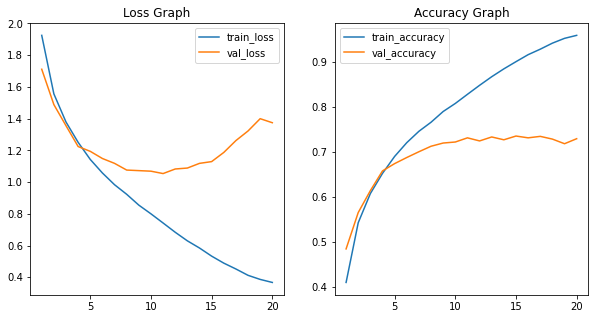

In [92]:
draw_history(history)

In [93]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.4336 - accuracy: 0.7203


[1.433579921722412, 0.720300018787384]

### Dropout

In [94]:
from tensorflow.keras.layers import Dropout

In [95]:
def get_model():
    model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', 
           input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Dropout(0.2),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Dropout(0.2),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-4), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [96]:
model = get_model()

In [97]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
1094/1094 [==============================] - 12s 11ms/step - loss: 1.9525 - accuracy: 0.2805 - val_loss: 1.4510 - val_accuracy: 0.4756
Epoch 2/20
1094/1094 [==============================] - 10s 9ms/step - loss: 1.4224 - accuracy: 0.4802 - val_loss: 1.2923 - val_accuracy: 0.5321
Epoch 3/20
1094/1094 [==============================] - 9s 8ms/step - loss: 1.2657 - accuracy: 0.5467 - val_loss: 1.1798 - val_accuracy: 0.5757
Epoch 4/20
1094/1094 [==============================] - 9s 8ms/step - loss: 1.1305 - accuracy: 0.5993 - val_loss: 1.0584 - val_accuracy: 0.6198
Epoch 5/20
1094/1094 [==============================] - 9s 8ms/step - loss: 1.0318 - accuracy: 0.6311 - val_loss: 0.9559 - val_accuracy: 0.6569
Epoch 6/20
1094/1094 [==============================] - 9s 8ms/step - loss: 0.9513 - accuracy: 0.6622 - val_loss: 0.8893 - val_accuracy: 0.6874
Epoch 7/20
1094/1094 [==============================] - 9s 8ms/step - loss: 0.8827 - accuracy: 0.6915 - val_loss: 0.8388 - val_accura

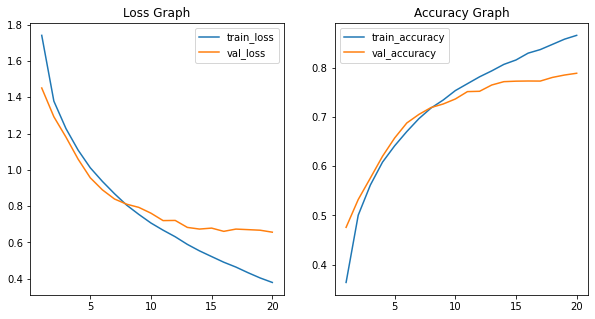

In [98]:
draw_history(history)

In [99]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.7085 - accuracy: 0.7748


[0.7085198760032654, 0.7748000025749207]

### Batch Normalization

In [100]:
from tensorflow.keras.layers import BatchNormalization, Activation

In [101]:
def get_model():
    model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', 
           input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),    
    Conv2D(filters=32, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Conv2D(filters=64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(filters=64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Conv2D(filters=128, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(filters=128, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-4), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [102]:
model = get_model()

In [103]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
1094/1094 [==============================] - 12s 10ms/step - loss: 1.6581 - accuracy: 0.4135 - val_loss: 1.1676 - val_accuracy: 0.5873
Epoch 2/20
1094/1094 [==============================] - 10s 10ms/step - loss: 1.0037 - accuracy: 0.6509 - val_loss: 0.9990 - val_accuracy: 0.6485
Epoch 3/20
1094/1094 [==============================] - 10s 10ms/step - loss: 0.7945 - accuracy: 0.7309 - val_loss: 0.9380 - val_accuracy: 0.6749
Epoch 4/20
1094/1094 [==============================] - 11s 10ms/step - loss: 0.6371 - accuracy: 0.7889 - val_loss: 0.9451 - val_accuracy: 0.6792
Epoch 5/20
1094/1094 [==============================] - 11s 10ms/step - loss: 0.4990 - accuracy: 0.8437 - val_loss: 0.9109 - val_accuracy: 0.6889
Epoch 6/20
1094/1094 [==============================] - 11s 10ms/step - loss: 0.3859 - accuracy: 0.8868 - val_loss: 0.9205 - val_accuracy: 0.6994
Epoch 7/20
1094/1094 [==============================] - 11s 10ms/step - loss: 0.2779 - accuracy: 0.9256 - val_loss: 0.9976 -

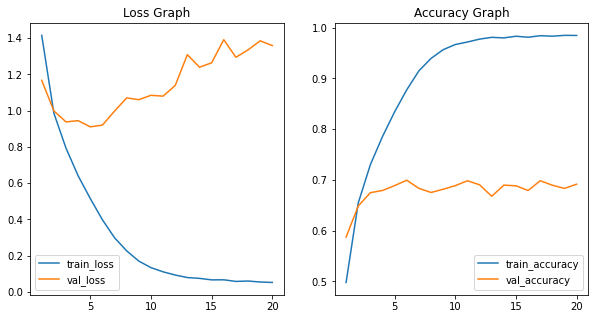

In [104]:
draw_history(history)

In [105]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4011 - accuracy: 0.6832


[1.4011327028274536, 0.6832000017166138]

### Data Augumentation